In [1]:
FOLD = 0


import os
import time
import math
import requests

# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
# os.environ["CUDA_VISIBLE_DEVICES"]=str(FOLD)

try:
    from itertools import  ifilterfalse
except ImportError: # py3k
    from itertools import  filterfalse

import numpy as np
import pandas as pd

import mlcrate as mlc

import os

import cv2

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import fbeta_score, accuracy_score, precision_score, recall_score

from skimage.transform import resize

from tqdm import tqdm

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import optim
from torch.optim import Optimizer
from torch.utils.data import Dataset, DataLoader
import torch.utils.checkpoint as checkpoint

import torchvision
from torchvision import transforms, utils

import apex
from apex.fp16_utils import FP16_Optimizer

from torchsummary import summary

from tensorboardX import SummaryWriter

SEED = 1337

NOTIFY_EACH_EPOCH = False

WORKERS = 24
BATCH_SIZE = 256

N_SPLITS = 8
SUBSET_SIZE = 100000
SUBSET_CLASSES = 100

np.random.seed(SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

writer = SummaryWriter()

def log(tag, value, iteration, multiple_scalars=False):
    if multiple_scalars == True:
        writer.add_scalars(f'data/{tag}', value, iteration)
    else:
        writer.add_scalar(f'data/{tag}', value, iteration)

def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

# from https://github.com/floydhub/save-and-resume
def save_checkpoint(state):
    """Save checkpoint if a new best is achieved"""
    print ("Saving checkpoint")

    filename = f'./checkpoint/checkpoint-{state["epoch"]}.pt.tar'
    torch.save(state, filename)
    
def initialize(path, model, optimizer=None):    
    checkpoint = torch.load(path)

    model.load_state_dict(checkpoint['model'])

    print(f'loaded checkpoint {path} | Trained for {checkpoint["epoch"] + 1} epochs')
    
    if optimizer:
        optimizer.load_state_dict(checkpoint['optimizer'])
          
        epoch = checkpoint['epoch'] + 1
        train_iteration = checkpoint['train_iteration']
        val_iteration = checkpoint['val_iteration']

        return model, optimizer, epoch, train_iteration, val_iteration
    else:
        return model
    
KEY = 'iDCO9Ns00jOTY_Db3KuaVLhjux-HKPp_tEtV8LEtesP'

def notify(title, message, key=KEY):
    report = {}
    report['value1'] = title
    report['value2'] = message

    requests.post(f'https://maker.ifttt.com/trigger/notify/with/key/{key}', data=report)

using non-fused syncBN, try install apex with 'python setup.py install --cuda_ext' to enable fused syncBN for better performance


In [2]:
classes_trainable = pd.read_csv('/home/kaggle/.kaggle/inclusive-images/classes-trainable.csv')
train_human_labels = pd.read_csv('/home/kaggle/.kaggle/inclusive-images/train_human_labels.csv')
stage_1_sample_submission = pd.read_csv('/home/kaggle/.kaggle/inclusive-images/stage_1_sample_submission.csv')
class_descriptions = pd.read_csv('/home/kaggle/.kaggle/inclusive-images/class-descriptions.csv')

In [3]:
top_100 = train_human_labels.LabelName.value_counts()[:SUBSET_CLASSES].index.values
train_human_labels = train_human_labels[train_human_labels.LabelName.isin(top_100)].reset_index(drop=True)

In [4]:
# only keep trainable labels in train_human_labels
# train_human_labels = train_human_labels[train_human_labels.LabelName.isin(temp)].reset_index()
train_human_labels = train_human_labels[train_human_labels.LabelName.isin(classes_trainable.label_code.values)].reset_index(drop=True)

# get indices for all rows and labels for indices
indices, labels = pd.factorize(train_human_labels.LabelName)
train_human_labels['indices'] = indices

In [5]:
class ImagesDataset(Dataset):
    def __init__(self, df, root_path, trainable_classes=None, size=256, img_id_col_name='ImageID', n_classes=7172):
        self.size = size
        self.n_classes = n_classes

        self.root_path = root_path

        self.df = df
        self.trainable_classes = trainable_classes

        self.img_id_col_name = img_id_col_name

        if self.trainable_classes is not None:
            self.img_ids = self.df[self.img_id_col_name]
            self.labels = self.df.indices.values

        self.ids = self.df[self.img_id_col_name].unique()
        
    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        
        if self.trainable_classes is not None:
            img_path = os.path.join(self.root_path, f'train_{img_id[0]}', f'{img_id}.jpg')
        else:
            img_path = os.path.join(self.root_path, f'{img_id}.jpg')
            
        img = cv2.imread(img_path)
        img = cv2.resize(img, (self.size, self.size))
        img = np.float32(img)
        img /= 255
        img = img.reshape(3, self.size, self.size)
        img = torch.from_numpy(img)
        
        if self.trainable_classes is not None:
            labels = np.where(self.img_ids == img_id)
            labels = self.labels[labels]
                        
            one_hot_labels = torch.zeros((self.n_classes))
            one_hot_labels[labels] = 1
            one_hot_labels = one_hot_labels
            
            sample = {'img': img, 'label': one_hot_labels}
        else:
            sample = {'img': img}
        
        return sample

In [6]:
class ResNet(nn.Module):
    def __init__(self, out_ch=7172, pretrained=False):
        super(ResNet, self).__init__()
        
        self.resnet = torchvision.models.resnet50(pretrained=pretrained)
    
        self.fe = nn.Sequential(
            self.resnet.conv1,
            self.resnet.bn1,
            self.resnet.relu,
            self.resnet.maxpool,
            self.resnet.layer1,
            self.resnet.layer2,
            self.resnet.layer3,
            self.resnet.layer4
        )
        
        self.avgpool = nn.AvgPool2d(8)
        
        self.logit = nn.Linear(2048, out_ch)

    def forward(self, x):
        x = self.fe(x)
        
        x = self.avgpool(x)
        
        x = x.view(x.size(0), -1)

        x = self.logit(x)
        
        return x

In [7]:
# from https://becominghuman.ai/investigating-focal-and-dice-loss-for-the-kaggle-2018-data-science-bowl-65fb9af4f36c
class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        # Inspired by the implementation of binary_cross_entropy_with_logits
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})".format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + ((-max_val).exp() + (-input - max_val).exp()).log()
        # This formula gives us the log sigmoid of 1-p if y is 0 and of p if y is 1
        invprobs = F.logsigmoid(-input * (target * 2 - 1)) 
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.mean()

# from https://www.kaggle.com/anokas/fixed-f2-score-in-python
def f2_score(y_true, y_pred):
    # fbeta_score throws a confusing error if inputs are not numpy arrays
    y_true, y_pred, = np.array(y_true), np.array(y_pred)
    # We need to use average='samples' here, any other average method will generate bogus results
    return fbeta_score(y_true, y_pred, beta=2, average='samples')

In [8]:
# use subset of 100k images
kfold = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
subset = np.random.choice(train_human_labels.ImageID.unique(), SUBSET_SIZE)
train_idx, val_idx = list(kfold.split(subset))[FOLD]

train_img_ids = subset[train_idx]
val_img_ids = subset[val_idx]
x_train, x_val = (train_human_labels[train_human_labels['ImageID'].isin(train_img_ids)]).reset_index(), (train_human_labels[train_human_labels['ImageID'].isin(val_img_ids)]).reset_index()

train_dataset = ImagesDataset(x_train, '/home/kaggle/.kaggle/inclusive-images/train', classes_trainable, n_classes=SUBSET_CLASSES)
val_dataset = ImagesDataset(x_val, '/home/kaggle/.kaggle/inclusive-images/train', classes_trainable, n_classes=SUBSET_CLASSES)
test_dataset = ImagesDataset(stage_1_sample_submission, '/home/kaggle/.kaggle/inclusive-images/stage-1-test-images', img_id_col_name='image_id', n_classes=SUBSET_CLASSES)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)

y_val = mlc.load('../../data/y_val_subset_100_classes.pkl.gz')
# y_val = np.zeros((len(val_dataset), SUBSET_CLASSES))

# for i, val in tqdm(enumerate(val_dataset), total=len(val_dataset)):
#     y_val[i] = val['label']

# mlc.save(y_val, '../../data/y_val_subset_100_classes.pkl.gz')

print(f'Train Dataset: {len(train_dataset)}')
print(f'Val Dataset: {len(val_dataset)}')
print(f'Test Dataset: {len(test_dataset)}')

Train Dataset: 85136
Val Dataset: 12447
Test Dataset: 32580


In [9]:
def view(idx, dataset, preds, test=False):
    plt.imshow(dataset[idx]['img'].reshape(256, 256, 3))
    if test == False:
        print(class_descriptions[class_descriptions['label_code'].isin(labels[list(np.where(dataset[idx]['label'] == 1)[0])])].reset_index())
    print(class_descriptions[class_descriptions['label_code'].isin(labels[list(np.where(preds[idx] == 1)[0])])].reset_index())

In [10]:
def find_lr(train_dataloader, init_value=1e-8, final_value=10., beta=0.98):
    model = ResNet(out_ch=SUBSET_CLASSES).to(device).half()
    model = nn.DataParallel(model)

    optimizer = optim.SGD(model.parameters(), lr=1e-1, momentum=0.9, weight_decay=1e-4)
    optimizer = FP16_Optimizer(optimizer, dynamic_loss_scale=True, verbose=False)

    criterion = nn.BCEWithLogitsLoss()
    
    num = len(train_dataloader)-1
    mult = (final_value / init_value) ** (1/num)
    lr = init_value
    optimizer.param_groups[0]['lr'] = lr
    avg_loss = 0.
    best_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    for i, batch in tqdm(enumerate(train_dataloader), total=(int(len(train_dataset) / BATCH_SIZE))):
        batch_num += 1

        img, label = batch['img'].to(device).half(), batch['label'].float().to(device).half()

        optimizer.zero_grad()
        out = model(img)
        loss = criterion(out, label)
        
        avg_loss = beta * avg_loss + (1-beta) *loss.item()
        smoothed_loss = avg_loss / (1 - beta**batch_num)
        
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            return log_lrs, losses
        
        if smoothed_loss < best_loss or batch_num==1:
            best_loss = smoothed_loss
        
        losses.append(smoothed_loss)
        log_lrs.append(math.log10(lr))
        
        optimizer.backward(loss)
        optimizer.step()
        
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr

    return log_lrs, losses

In [11]:
start_epoch = 0
epochs = 50
early_stopping = 15

train_iteration = 0
val_iteration = 0

threshold = 0.2

model = ResNet(out_ch=SUBSET_CLASSES).to(device).half()
model = nn.DataParallel(model)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
optimizer = FP16_Optimizer(optimizer, dynamic_loss_scale=True, verbose=False)

criterion = nn.BCEWithLogitsLoss()

model, optimizer, start_epoch, train_iteration, val_iteration = initialize('./checkpoint/checkpoint-22.pt.tar', model, optimizer)

# summary(model, input_size=(3, 256, 256))

loaded checkpoint ./checkpoint/checkpoint-22.pt.tar | Trained for 23 epochs


In [13]:
best_train_loss = 1e10
best_val_loss = 1e10

best_train_f2 = 0
best_val_f2 = 0

best_epoch = 0

for epoch in range(start_epoch, epochs):
    print(f'\n Starting Epoch {epoch} | LR: {optimizer.param_groups[0]["lr"]}')
        
    train_loss = 0
    val_loss = 0

    train_iou = 0
    val_iou = 0

    model.train()
    for i, batch in tqdm(enumerate(train_dataloader), total=(int(len(train_dataset) / BATCH_SIZE))):
        img, label = batch['img'].to(device).half(), batch['label'].to(device).half()
          
        out = model(img)
        
        loss = criterion(out, label)

        log('train_loss_iteration', loss.item(), train_iteration)
        train_loss += loss.item()

        optimizer.zero_grad()
        
        optimizer.backward(loss)
        optimizer.step()
          
        train_iteration += 1
          
    model.eval()
    with torch.no_grad():  
        val_preds = np.zeros((len(val_dataset), SUBSET_CLASSES), dtype=np.float32)
        for j, batch in tqdm(enumerate(val_dataloader), total=(int(len(val_dataset) / BATCH_SIZE))):
            img, label = batch['img'].to(device).half(), batch['label'].to(device).half()

            out = model(img)
            
            loss = criterion(out, label)

            log('val_loss_iteration', loss.item(), val_iteration)
            val_loss += loss.item()

            optimizer.zero_grad()
          
            pred = torch.sigmoid(out)
            pred = pred.to('cpu').detach().numpy()
            pred = pred.reshape(-1, SUBSET_CLASSES)
            val_preds[j*BATCH_SIZE:j*BATCH_SIZE+BATCH_SIZE] = pred
          
            val_iteration += 1

    val_preds_raw = val_preds
    val_preds = (val_preds > threshold).astype(int)

    train_loss /= (i + 1)
    val_loss /= (j + 1)
          
    train_f2 = 0
    val_f2 = f2_score(y_val, val_preds)
    
    log('lr', optimizer.param_groups[0]["lr"], epoch)
    
    log('epoch_loss', {'train_loss': train_loss, 'val_loss': val_loss}, epoch, multiple_scalars=True)
    log('epoch_f2', {'train_f2': train_f2, 'val_f2': val_f2}, epoch, multiple_scalars=True)
                  
    print(f' End of Epoch {epoch} | Train Loss: {train_loss} | Val Loss: {val_loss} | Train F2: {round(train_f2, 4)} | Val F2: {round(val_f2, 4)}')
    if NOTIFY_EACH_EPOCH:
        notify(f'Fold: {FOLD} | Epoch {epoch} Ended', f'Train Loss: {round(train_loss, 4)} | Val Loss: {round(val_loss, 4)} | Train F2: {round(train_f2, 4)} | Val F2: {round(val_f2, 4)}')
          
    scheduler.step(val_loss)
          
    if val_loss < best_val_loss:
        best_epoch = epoch

        best_train_loss = train_loss
        best_val_loss = val_loss

        best_train_f2 = train_f2
        best_val_f2 = val_f2
          
        save_checkpoint({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch,
            'train_iteration': train_iteration,
            'val_iteration': val_iteration
        })
        print(f'Val loss has decreased, saving model at epoch {epoch}')

    elif epoch - best_epoch > early_stopping:
        print(f' Val loss has not decreased for {early_stopping} epochs, stopping training')
        notify(f'Fold: {FOLD} | Early stopping at epoch {epoch}', f'Val loss has not decreased for {early_stopping} epochs, stopping training')
        break


 Starting Epoch 23 | LR: 0.010000000000000002


333it [06:25,  1.21it/s]                         
49it [00:52,  2.74it/s]                        
/home/kaggle/anaconda3/envs/inclusive-images/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


 End of Epoch 23 | Train Loss: 0.08463779942051426 | Val Loss: 0.08913125797193877 | Train F2: 0 | Val F2: 0.2399
Saving checkpoint
Val loss has decreased, saving model at epoch 23

 Starting Epoch 24 | LR: 0.010000000000000002


 10%|▉         | 33/332 [00:53<05:05,  1.02s/it]

OVERFLOW! Skipping step. Attempted loss scale: 65536.0, reducing to 32768.0


333it [05:42,  1.19it/s]                         
49it [00:24,  3.40it/s]                        


 End of Epoch 24 | Train Loss: 0.08419295760604355 | Val Loss: 0.0888248365752551 | Train F2: 0 | Val F2: 0.2395
Saving checkpoint
Val loss has decreased, saving model at epoch 24

 Starting Epoch 25 | LR: 0.010000000000000002


333it [05:42,  1.18it/s]                         
49it [00:25,  3.39it/s]                        


 End of Epoch 25 | Train Loss: 0.08386890308277027 | Val Loss: 0.09166733099489796 | Train F2: 0 | Val F2: 0.2289

 Starting Epoch 26 | LR: 0.010000000000000002


333it [05:41,  1.19it/s]                         
49it [00:24,  3.38it/s]                        


 End of Epoch 26 | Train Loss: 0.08337457330377253 | Val Loss: 0.08911506497130102 | Train F2: 0 | Val F2: 0.2356

 Starting Epoch 27 | LR: 0.010000000000000002


 11%|█         | 35/332 [00:55<04:57,  1.00s/it]

OVERFLOW! Skipping step. Attempted loss scale: 65536.0, reducing to 32768.0


333it [05:42,  1.20it/s]                         
49it [00:24,  3.39it/s]                        

 End of Epoch 27 | Train Loss: 0.08303237319350601 | Val Loss: 0.08929318797831633 | Train F2: 0 | Val F2: 0.2308

 Starting Epoch 28 | LR: 0.010000000000000002



333it [05:43,  1.21it/s]                         
49it [00:24,  3.40it/s]                        


 End of Epoch 28 | Train Loss: 0.08252374689142267 | Val Loss: 0.09001689054528061 | Train F2: 0 | Val F2: 0.2365

 Starting Epoch 29 | LR: 0.010000000000000002


333it [05:42,  1.20it/s]                         
49it [00:24,  3.42it/s]                        


 End of Epoch 29 | Train Loss: 0.08202978368993993 | Val Loss: 0.09075180365114796 | Train F2: 0 | Val F2: 0.2215

 Starting Epoch 30 | LR: 0.010000000000000002


 11%|█         | 37/332 [00:55<04:55,  1.00s/it]

OVERFLOW! Skipping step. Attempted loss scale: 65536.0, reducing to 32768.0


333it [05:41,  1.19it/s]                         
49it [00:25,  3.39it/s]                        


 End of Epoch 30 | Train Loss: 0.08154223559496997 | Val Loss: 0.09012152224170919 | Train F2: 0 | Val F2: 0.2326
Epoch     7: reducing learning rate of group 0 to 1.0000e-03.

 Starting Epoch 31 | LR: 0.0010000000000000002


333it [05:42,  1.19it/s]                         
49it [00:24,  3.40it/s]                        


 End of Epoch 31 | Train Loss: 0.08003816805086336 | Val Loss: 0.08922343351403061 | Train F2: 0 | Val F2: 0.2325

 Starting Epoch 32 | LR: 0.0010000000000000002


333it [05:42,  1.19it/s]                         
49it [00:24,  3.41it/s]                        

 End of Epoch 32 | Train Loss: 0.07973244240334085 | Val Loss: 0.08918731066645408 | Train F2: 0 | Val F2: 0.2316

 Starting Epoch 33 | LR: 0.0010000000000000002



 12%|█▏        | 39/332 [00:57<04:45,  1.03it/s]

OVERFLOW! Skipping step. Attempted loss scale: 65536.0, reducing to 32768.0


333it [05:41,  1.20it/s]                         
49it [00:24,  3.37it/s]                        


 End of Epoch 33 | Train Loss: 0.0795799461570946 | Val Loss: 0.08926080197704081 | Train F2: 0 | Val F2: 0.2333

 Starting Epoch 34 | LR: 0.0010000000000000002


333it [05:41,  1.19it/s]                         
49it [00:24,  3.38it/s]                        


 End of Epoch 34 | Train Loss: 0.07946575726116742 | Val Loss: 0.0892147142059949 | Train F2: 0 | Val F2: 0.2335

 Starting Epoch 35 | LR: 0.0010000000000000002


333it [05:41,  1.19it/s]                         
49it [00:24,  3.32it/s]                        


 End of Epoch 35 | Train Loss: 0.07927348735454204 | Val Loss: 0.08931062659438775 | Train F2: 0 | Val F2: 0.2339

 Starting Epoch 36 | LR: 0.0010000000000000002


 12%|█▏        | 41/332 [01:00<04:42,  1.03it/s]

OVERFLOW! Skipping step. Attempted loss scale: 65536.0, reducing to 32768.0


333it [05:42,  1.19it/s]                         
49it [00:23,  3.37it/s]                        


 End of Epoch 36 | Train Loss: 0.07914481864677177 | Val Loss: 0.08944515306122448 | Train F2: 0 | Val F2: 0.2361
Epoch    13: reducing learning rate of group 0 to 1.0000e-04.

 Starting Epoch 37 | LR: 0.00010000000000000003


333it [05:41,  1.19it/s]                         
49it [00:23,  3.41it/s]                        

 End of Epoch 37 | Train Loss: 0.07900496932479355 | Val Loss: 0.08941027582908163 | Train F2: 0 | Val F2: 0.2316

 Starting Epoch 38 | LR: 0.00010000000000000003



333it [05:41,  1.19it/s]                         
49it [00:24,  3.40it/s]                        

 End of Epoch 38 | Train Loss: 0.07890471037443694 | Val Loss: 0.08941525829081633 | Train F2: 0 | Val F2: 0.233

 Starting Epoch 39 | LR: 0.00010000000000000003



 13%|█▎        | 43/332 [01:01<04:37,  1.04it/s]

OVERFLOW! Skipping step. Attempted loss scale: 65536.0, reducing to 32768.0


333it [05:41,  1.19it/s]                         
49it [00:24,  3.39it/s]                        

 End of Epoch 39 | Train Loss: 0.07884550810576202 | Val Loss: 0.08950120575573979 | Train F2: 0 | Val F2: 0.2301

 Starting Epoch 40 | LR: 0.00010000000000000003



333it [05:42,  1.19it/s]                         
49it [00:23,  3.39it/s]                        


 End of Epoch 40 | Train Loss: 0.07889041385135136 | Val Loss: 0.08941027582908163 | Train F2: 0 | Val F2: 0.2256
 Val loss has not decreased for 15 epochs, stopping training


In [14]:
notify(f'Fold: {FOLD} | Best Epoch: {best_epoch}', f'Best train Loss: {round(best_train_loss, 4)} | Best val Loss: {round(best_val_loss, 4)} | Best train F2: {round(best_train_f2, 4)} | \
Best Val F2: {round(best_val_f2, 4)}')

In [15]:
f2_score(y_val, val_preds)

0.2256334960972021

In [16]:
precision_score(y_val, val_preds, average='samples')

/home/kaggle/anaconda3/envs/inclusive-images/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


0.2335871918000142

In [17]:
recall_score(y_val, val_preds, average='samples')

0.2442721518847233

   index label_code description
0    892  /m/01bqvp         Sky
1   7897   /m/03jm5       House
2  11909   /m/05s2s       Plant
3  13801   /m/07j7r        Tree
4  16697   /m/0csby       Cloud
5  16878   /m/0d4v4      Window
   index label_code description
0   1206  /m/01g317      Person
1  11909   /m/05s2s       Plant
2  13801   /m/07j7r        Tree
3  16452   /m/0cgh4    Building


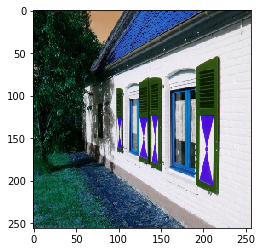

In [39]:
view(0, val_dataset, val_preds)

In [69]:
model = ResNet(out_ch=SUBSET_CLASSES).to(device).half()
model = nn.DataParallel(model)
model = initialize('./checkpoint/checkpoint-24.pt.tar', model)

preds = np.zeros((len(test_dataset), SUBSET_CLASSES), dtype=np.float32)

model.eval()
with torch.no_grad():
    for i, batch in tqdm(enumerate(test_dataloader), total=int(len(test_dataset) / BATCH_SIZE)):
        img = batch['img'].to(device).half()
        
        out = model(img)
        out = torch.sigmoid(out)
        pred = out.to('cpu').detach().numpy()
        pred = pred.reshape(-1, SUBSET_CLASSES)
        preds[i*BATCH_SIZE:i*BATCH_SIZE+BATCH_SIZE] = pred
        
preds = (preds > threshold).astype(int)

loaded checkpoint ./checkpoint/checkpoint-24.pt.tar | Trained for 25 epochs


128it [00:45,  2.81it/s]                         


   index label_code   description
0   1206  /m/01g317        Person
1   1924  /m/01prls  Land vehicle
2  11909   /m/05s2s         Plant
3  13801   /m/07j7r          Tree
4  14184   /m/07yv9       Vehicle
5  15243   /m/09j2d      Clothing
6  19466    /m/0k4j           Car


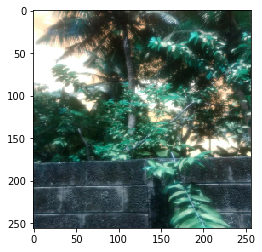

In [70]:
view(0, test_dataset, preds, test=True)

In [71]:
def submit(preds):
    pred_labels = []

    for pred in preds:
        pred_labels.append(labels[np.where(pred == 1)])

    pred_labels_string = []
    for pred_label in pred_labels:
        pred_labels_string.append(' '.join([i for i in pred_label]))
        
    submission = stage_1_sample_submission.copy()
    submission['labels'] = pred_labels_string
    
    mlc.kaggle.save_sub(submission, 'submission.csv')
    
    print(submission.head())

In [72]:
submit(preds)

                   image_id                                             labels
0  2b2b327132556c767a736b3d  /m/01g317 /m/09j2d /m/01prls /m/05s2s /m/07j7r...
1  2b2b394755692f303963553d  /m/01g317 /m/09j2d /m/01prls /m/07yv9 /m/0jbk ...
2  2b2b42584e6d445937444d3d                         /m/05s2s /m/07j7r /m/0838f
3  2b2b44744e57674270616f3d                        /m/0c9ph5 /m/05s2s /m/07j7r
4  2b2b4b425a592b683059493d  /m/01g317 /m/09j2d /m/0c_jw /m/0dzct /m/01prls...


In [73]:
# !kaggle competitions submit -c inclusive-images-challenge -f submission.csv -m "resnet 50 100 classes 24 epochs"

100%|██████████████████████████████████████| 2.57M/2.57M [00:00<00:00, 7.37MB/s]
Successfully submitted to Inclusive Images Challenge